Please use this link, it direct to this notebook only! Will simplify the replication!

https://colab.research.google.com/drive/1L6Lw2slHppE3r3SgEnwD_HLOWWCBbeHV?usp=sharing


**Imprting Libraries**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

**Signals**

In [ ]:
df = pd.read_csv("enter csv file name here")
df['mid_price'] = (df['ask price'] + df['bid price']) / 2
df['momentum'] = df['mid_price'].diff(periods=50).fillna(0)
df['datetime'] = pd.to_datetime(df['time'], unit='s', origin='unix')
df.set_index('datetime', inplace=True)
df.sort_index(inplace=True)
df['minute'] = df.index.floor('min')
df['spread'] = df['ask price'] - df['bid price']
# Rolling quantile window changed to last 5 minutes
window = '5min'
df['spread_q10'] = df['spread'].rolling(window).quantile(0.1)
df['volume_imbalance'] = (df['bid volume'] - df['ask volume']) / (df['bid volume'] + df['ask volume'] + 1e-6)
df['vol_imb_q95'] = df['volume_imbalance'].rolling(window).quantile(0.95)
df["trade_intensity"] = df["order id"].rolling('15s').count().values
df['trade_intensity_q10'] = df['trade_intensity'].rolling(window).quantile(0.1)
df["volume_curve_30s"] = df["size"].rolling("30s").sum().fillna(0)
df["volume_curve_baseline"] = df["volume_curve_30s"].rolling("5min").mean()
df["volume_curve_deviation"] = df["volume_curve_30s"] - df["volume_curve_baseline"]
df["volume_curve_deviation_q20"] = df["volume_curve_deviation"].rolling(window).quantile(0.2)
df['vol_imb_q05'] = df['volume_imbalance'].rolling(window).quantile(0.05)
df['momentum_q80'] = df['momentum'].rolling(window).quantile(0.80)
df['momentum_q20'] = df['momentum'].rolling(window).quantile(0.20)
# Aggression Ratio: Assuming aggressive trades impact either ask_volume or bid_volume
# Changes in volume are aggressive if volume sharply decreases at bid/ask
df["delta_ask_vol"] = df["ask volume"].diff()
df["delta_bid_vol"] = df["bid volume"].diff()
# Define aggressive trade as negative volume diff (market order hitting limit order)
df["aggressive_trades"] = ((df["delta_ask_vol"] < 0).astype(int) + (df["delta_bid_vol"] < 0).astype(int))
# Rolling aggression ratio (number of aggressive ticks in recent ticks window)
df["aggression_ratio"] = df["aggressive_trades"].rolling('30s').mean()
df["aggression_ratio_q80"] = df["aggression_ratio"].rolling(window).quantile(0.8).fillna(0)

# **Use the below given parameters in the Execution algorithm by manually adding before executing for the respective stock please!**

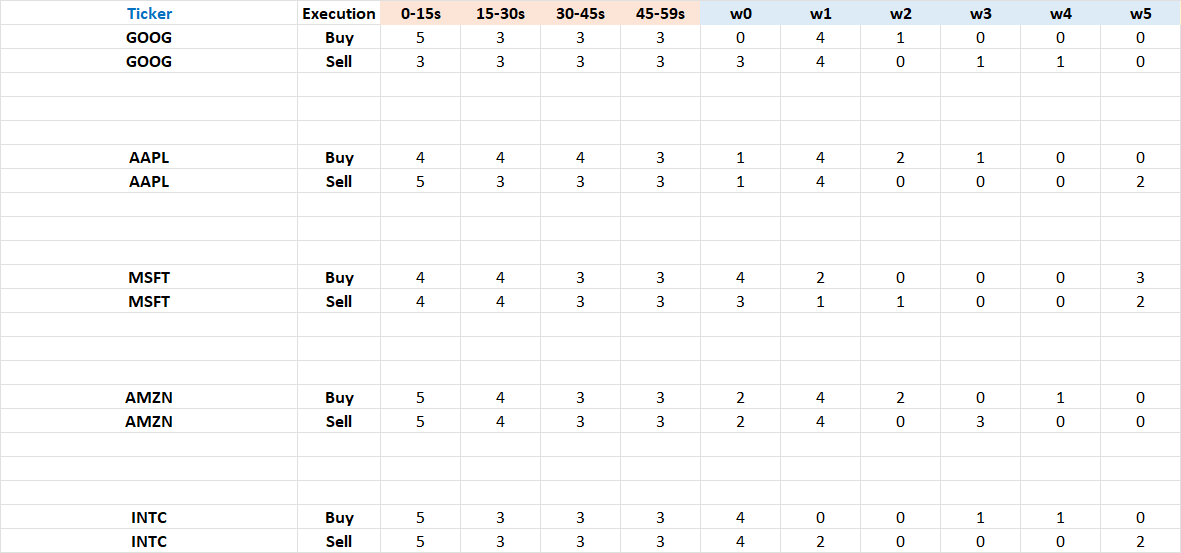

**Buy Execution**

In [ ]:
# Assign time zone to each row based on the second
def assign_zone(second):
    if second < 15:
        return '0–15s'
    elif second < 30:
        return '15–30s'
    elif second < 45:
        return '30–45s'
    else:
        return '45–59s'
df['second'] = df.index.second
df['time_zone'] = df['second'].apply(assign_zone)


# Define zone-specific thresholds for signal flags
zone_thresholds = {
    '0–15s': add number here,
    '15–30s': add number here,
    '30–45s': add number here,
    '45–59s': add number here
}


# Initialize lists and dictionaries
all_minutes = sorted(df['minute'].unique())
exec_algo_prices = []
twap_first_sec_prices = []
timestamps = []
buy_prices_algo = []
buy_prices_twap = []
signal_counts = {
    'Volume Imbalance': 0,
    'Spread': 0,
    'Momentum': 0,
    "Trade Intensity": 0,
    "Volume Curve Deviation": 0,
    "Aggressive trades": 0
}
signal_price_improvements = {
    'Volume Imbalance': [],
    'Spread': [],
    'Momentum': [],
    "Trade Intensity": [],
    "Volume Curve Deviation": [],
    "Aggressive trades": []
}
# Main execution loop
for i in range(len(all_minutes)):
    current_minute = all_minutes[i]
    minute_data = df[df['minute'] == current_minute]
    if minute_data.empty:
        continue
    first_second_data = minute_data[minute_data.index.second == 0]
    twap_first_price = first_second_data.iloc[0]['ask price'] if not first_second_data.empty else minute_data.iloc[0]['ask price']
    executed = False
    for _, row in minute_data.iterrows():
        if row.name.second > 59:
            continue
        current_zone = row['time_zone']
        threshold = zone_thresholds.get(current_zone, 3)
        # Signal conditions
        signal_volume_imb = row['volume_imbalance'] > row['vol_imb_q95']
        signal_spread = row['spread'] < row['spread_q10']
        signal_momentum = row['momentum'] > row['momentum_q80']
        signal_trade_intensity = row['trade_intensity'] < row['trade_intensity_q10']
        signal_volume_curve_dev = row["volume_curve_deviation"] < row["volume_curve_deviation_q20"]
        signal_agg = row["aggression_ratio"] > row["aggression_ratio_q80"]


        signal_flags = [w0*signal_volume_imb, w1*signal_spread, w3*signal_momentum,
                        w4*signal_trade_intensity, w5*signal_volume_curve_dev, w6*signal_agg]


        if sum(signal_flags) > threshold:
            exec_price = row['ask price']
            price_improvement = twap_first_price - exec_price
            if signal_volume_imb:
                signal_counts['Volume Imbalance'] += 1
                signal_price_improvements['Volume Imbalance'].append(price_improvement)
            if signal_spread:
                signal_counts['Spread'] += 1
                signal_price_improvements['Spread'].append(price_improvement)
            if signal_momentum:
                signal_counts['Momentum'] += 1
                signal_price_improvements['Momentum'].append(price_improvement)
            if signal_trade_intensity:
                signal_counts["Trade Intensity"] += 1
                signal_price_improvements["Trade Intensity"].append(price_improvement)
            if signal_volume_curve_dev:
                signal_counts["Volume Curve Deviation"] += 1
                signal_price_improvements["Volume Curve Deviation"].append(price_improvement)
            if signal_agg:
                signal_counts["Aggressive trades"] += 1
                signal_price_improvements["Aggressive trades"].append(price_improvement)
            executed = True
            break
    if not executed:
        exec_price = minute_data.iloc[-1]['ask price']
    exec_algo_prices.append(exec_price)
    twap_first_sec_prices.append(twap_first_price)
    timestamps.append(current_minute)
    buy_prices_algo.append(exec_price)
    buy_prices_twap.append(twap_first_price)
# Build results DataFrame
results = pd.DataFrame({
    'time': timestamps,
    'exec_algo_price': exec_algo_prices,
    'twap_first_sec_price': twap_first_sec_prices
})
results['time'] = pd.to_datetime(results['time'])
results.set_index('time', inplace=True)
# Summary statistics
print(f"Execution Algo Avg Price: {results['exec_algo_price'].mean():.5f}")
print(f"TWAP First Second Avg Price: {results['twap_first_sec_price'].mean():.5f}")
print("\nSignal Trigger Counts (ONLY when Buy triggered):")
for signal, count in signal_counts.items():
    print(f"{signal}: {count}")
better_execution = (results['exec_algo_price'] < results['twap_first_sec_price']).sum()
worse_execution = (results['exec_algo_price'] > results['twap_first_sec_price']).sum()
same_execution = (results['exec_algo_price'] == results['twap_first_sec_price']).sum()
print("\nComparison between Execution Algo and TWAP:")
print(f"Better Execution (Algo < TWAP): {better_execution}")
print(f"Worse Execution (Algo > TWAP): {worse_execution}")
print(f"Same Execution (Algo = TWAP): {same_execution}")
plt.figure(figsize=(6, 4))
colors = ['#1f77b4', '#ff7f0e', '#d62728']
plt.bar(['TWAP Better', 'Algo Better', 'Same'],
        [worse_execution, better_execution, same_execution], color=colors)
plt.title('Execution Comparison: Algo vs TWAP')
plt.ylabel('Number of Trades')
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()
# Timing classification
buy_timing = []
for i in range(len(timestamps)):
    minute = timestamps[i]
    minute_data = df[df['minute'] == minute]
    if minute_data.empty:
        buy_timing.append('Last Second Buy')
        continue
    exec_price = exec_algo_prices[i]
    twap_price = twap_first_sec_prices[i]
    exec_time = None
    for idx, row in minute_data.iterrows():
        if row['ask price'] == exec_price:
            exec_time = idx
            break
    first_sec_data = minute_data[minute_data.index.second == 0]
    twap_time = first_sec_data.index[0] if not first_sec_data.empty else minute_data.index[0]
    last_time = minute_data.index[-1]
    if exec_time is None:
        buy_timing.append('Last Second Buy')
    elif exec_time == twap_time:
        buy_timing.append('Same as TWAP')
    elif exec_time != last_time:
        buy_timing.append('B/W TWAP & Last Second')
    else:
        buy_timing.append('Last Second Buy')
timing_counts = Counter(buy_timing)
print("\nPrecise Timing Categories:")
for k, v in timing_counts.items():
    print(f"{k}: {v}")
categories = ['Same as TWAP', 'B/W TWAP & Last Second', 'Last Second Buy']
colors = ['#1f77b4', '#ff7f0e', '#d62728']
counts = [timing_counts.get(cat, 0) for cat in categories]
plt.figure(figsize=(6, 4))
bars = plt.bar(categories, counts, color=colors)
plt.title('Execution Timing Distribution')
plt.ylabel('Number of Trades')
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()
# Average price improvement per signal
avg_improvement_per_signal = {
    sig: np.mean(vals) if vals else 0
    for sig, vals in signal_price_improvements.items()
}
plt.figure(figsize=(8, 4))
signals = list(avg_improvement_per_signal.keys())
improvements = [avg_improvement_per_signal[sig] for sig in signals]
plt.bar(signals, improvements, color='#2ca02c')
plt.axhline(0, color='gray', linewidth=0.8, linestyle='--')
plt.xticks(rotation=45)
plt.ylabel("Average Price Improvement")
plt.title("Average Price Improvement per Signal")
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()
# Zonal trade timing analysis
zone_bins = [(0, 15), (15, 30), (30, 45), (45, 60)]
zone_labels = ['0–15s', '15–30s', '30–45s', '45–59s']
zone_trade_counts = {label: 0 for label in zone_labels}
zone_price_improvements = {label: [] for label in zone_labels}
for i in range(len(timestamps)):
    minute = timestamps[i]
    minute_data = df[df['minute'] == minute]
    exec_price = exec_algo_prices[i]
    twap_price = twap_first_sec_prices[i]
    for idx, row in minute_data.iterrows():
        if row['ask price'] == exec_price:
            sec = idx.second
            price_improvement = twap_price - exec_price
            for (start, end), label in zip(zone_bins, zone_labels):
                if start <= sec < end:
                    zone_trade_counts[label] += 1
                    zone_price_improvements[label].append(price_improvement)
                    break
            break
# Convert to arrays for further calculations
buy_prices_algo = np.array(buy_prices_algo)
buy_prices_twap = np.array(buy_prices_twap)
print(np.mean(buy_prices_twap - buy_prices_algo)
# Plot: Number of Trades per Zone
plt.figure(figsize=(6, 4))
plt.bar(zone_labels, [zone_trade_counts[z] for z in zone_labels], color='#1f77b4')
plt.title("Number of Executions per Time Zone in Minute")
plt.xlabel("Time Zone")
plt.ylabel("Trade Count")
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()
# Plot: Average Price Improvement per Zone
avg_improvement_by_zone = [np.mean(zone_price_improvements[z]) if zone_price_improvements[z] else 0 for z in zone_labels]
plt.figure(figsize=(6, 4))
plt.bar(zone_labels, avg_improvement_by_zone, color='#2ca02c')
plt.title("Average Price Improvement per Time Zone")
plt.xlabel("Time Zone")
plt.ylabel("Avg Price Improvement (TWAP - Exec)")
plt.axhline(0, color='gray', linestyle='--')
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

**Sell Execution**

In [ ]:
# Assign second and time zone to each row
def assign_zone(second):
    if second < 15:
        return '0–15s'
    elif second < 30:
        return '15–30s'
    elif second < 45:
        return '30–45s'
    else:
        return '45–59s'
df['second'] = df.index.second
df['time_zone'] = df['second'].apply(assign_zone)

# Zone-specific signal thresholds
zone_thresholds_sell = {
    '0–15s': add number here,
    '15–30s': add number here,
    '30–45s': add number here,
    '45–59s': add number here
}


all_minutes = sorted(df['minute'].unique())
exec_algo_prices_sell = []
twap_first_sec_prices_sell = []
timestamps_sell = []
sell_prices_algo = []
sell_prices_twap = []
# Signal counters
signal_counts_sell = {
    'Volume Imbalance': 0,
    'Spread': 0,
    'Momentum': 0,
    "Trade Intensity": 0,
    "Volume Curve Deviation": 0,
    "Aggressive trades": 0
}
# For improvement analysis
signal_price_improvements_sell = {
    'Volume Imbalance': [],
    'Spread': [],
    'Momentum': [],
    "Trade Intensity": [],
    "Volume Curve Deviation": [],
    "Aggressive trades": []
}
for i in range(len(all_minutes)):
    current_minute = all_minutes[i]
    minute_data = df[df['minute'] == current_minute]
    if minute_data.empty:
        continue
    first_second_data = minute_data[minute_data.index.second == 0]
    twap_first_price = first_second_data.iloc[0]['bid price'] if not first_second_data.empty else minute_data.iloc[0]['bid price']
    executed = False
    for _, row in minute_data.iterrows():
        if row.name.second > 59:
            continue
        current_zone = row['time_zone']
        threshold = zone_thresholds_sell.get(current_zone, 3)
        # SELL-side signal logic
        signal_volume_imb = row['volume_imbalance'] < row['vol_imb_q05']
        signal_spread = row['spread'] < row['spread_q10']
        signal_momentum = row['momentum'] < row['momentum_q20']
        signal_trade_intensity = row['trade_intensity'] < row['trade_intensity_q10']
        signal_volume_curve_dev = row["volume_curve_deviation"] < row["volume_curve_deviation_q20"]
        signal_agg = row["aggression_ratio"] > row["aggression_ratio_q80"]


        signal_flags = [w0*signal_volume_imb, w1*signal_spread, w2*signal_momentum,
                        w3*signal_trade_intensity, w4*signal_volume_curve_dev, w5*signal_agg]


        if sum(signal_flags) > threshold:
            exec_price = row['bid price']
            price_improvement = exec_price - twap_first_price
            if signal_volume_imb:
                signal_counts_sell['Volume Imbalance'] += 1
                signal_price_improvements_sell['Volume Imbalance'].append(price_improvement)
            if signal_spread:
                signal_counts_sell['Spread'] += 1
                signal_price_improvements_sell['Spread'].append(price_improvement)
            if signal_momentum:
                signal_counts_sell['Momentum'] += 1
                signal_price_improvements_sell['Momentum'].append(price_improvement)
            if signal_trade_intensity:
                signal_counts_sell["Trade Intensity"] += 1
                signal_price_improvements_sell["Trade Intensity"].append(price_improvement)
            if signal_volume_curve_dev:
                signal_counts_sell["Volume Curve Deviation"] += 1
                signal_price_improvements_sell["Volume Curve Deviation"].append(price_improvement)
            if signal_agg:
                signal_counts_sell["Aggressive trades"] += 1
                signal_price_improvements_sell["Aggressive trades"].append(price_improvement)
            executed = True
            break
    if not executed:
        exec_price = minute_data.iloc[-1]['bid price']
    exec_algo_prices_sell.append(exec_price)
    twap_first_sec_prices_sell.append(twap_first_price)
    timestamps_sell.append(current_minute)
    sell_prices_algo.append(exec_price)
    sell_prices_twap.append(twap_first_price)
# Compile sell-side results
results_sell = pd.DataFrame({
    'time': timestamps_sell,
    'exec_algo_price': exec_algo_prices_sell,
    'twap_first_sec_price': twap_first_sec_prices_sell
})
results_sell['time'] = pd.to_datetime(results_sell['time'])
results_sell.set_index('time', inplace=True)
# Summary stats
print(f"Execution Algo Avg Sell Price: {results_sell['exec_algo_price'].mean():.5f}")
print(f"TWAP First Second Avg Sell Price: {results_sell['twap_first_sec_price'].mean():.5f}")
print("\nSell Signal Trigger Counts (ONLY when Sell triggered):")
for signal, count in signal_counts_sell.items():
    print(f"{signal}: {count}")
better_exec = (results_sell['exec_algo_price'] > results_sell['twap_first_sec_price']).sum()
worse_exec = (results_sell['exec_algo_price'] < results_sell['twap_first_sec_price']).sum()
same_exec = (results_sell['exec_algo_price'] == results_sell['twap_first_sec_price']).sum()
print("\nComparison between Sell Execution Algo and TWAP:")
print(f"Better Execution (Algo > TWAP): {better_exec}")
print(f"Worse Execution (Algo < TWAP): {worse_exec}")
print(f"Same Execution (Algo = TWAP): {same_exec}")
# Plot comparison
plt.figure(figsize=(6, 4))
colors = ['#1f77b4', '#ff7f0e', '#d62728']
plt.bar(['TWAP Better', 'Algo Better', 'Same'],
        [worse_exec, better_exec, same_exec], color=colors)
plt.title('Sell Execution Comparison: Algo vs TWAP')
plt.ylabel('Number of Trades')
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()
# Timing analysis
sell_timing = []
for i in range(len(timestamps_sell)):
    minute = timestamps_sell[i]
    minute_data = df[df['minute'] == minute]
    if minute_data.empty:
        sell_timing.append('Last Second Sell')
        continue
    exec_price = exec_algo_prices_sell[i]
    twap_price = twap_first_sec_prices_sell[i]
    exec_time = None
    for idx, row in minute_data.iterrows():
        if row['bid price'] == exec_price:
            exec_time = idx
            break
    first_sec_data = minute_data[minute_data.index.second == 0]
    twap_time = first_sec_data.index[0] if not first_sec_data.empty else minute_data.index[0]
    last_time = minute_data.index[-1]
    if exec_time is None:
        sell_timing.append('Last Second Sell')
    elif exec_time == twap_time:
        sell_timing.append('Same as TWAP')
    elif exec_time != last_time:
        sell_timing.append('B/W TWAP & Last Second')
    else:
        sell_timing.append('Last Second Sell')
timing_counts_sell = Counter(sell_timing)
print("\nSell Timing Categories:")
for k, v in timing_counts_sell.items():
    print(f"{k}: {v}")
categories = ['Same as TWAP', 'B/W TWAP & Last Second', 'Last Second Sell']
colors = ['#1f77b4', '#ff7f0e', '#d62728']
counts = [timing_counts_sell.get(cat, 0) for cat in categories]
plt.figure(figsize=(6, 4))
plt.bar(categories, counts, color=colors)
plt.title('Sell Execution Timing Distribution')
plt.ylabel('Number of Trades')
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()
# Average price improvement per signal
avg_improvement_per_signal_sell = {
    sig: np.mean(vals) if vals else 0
    for sig, vals in signal_price_improvements_sell.items()
}
plt.figure(figsize=(8, 4))
signals = list(avg_improvement_per_signal_sell.keys())
improvements = [avg_improvement_per_signal_sell[sig] for sig in signals]
plt.bar(signals, improvements, color='#d62728')
plt.axhline(0, color='gray', linewidth=0.8, linestyle='--')
plt.xticks(rotation=45)
plt.ylabel("Average Price Improvement")
plt.title("Average Price Improvement per Signal (Sell Side)")
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()
# Zonal analysis
zone_bins = [(0, 15), (15, 30), (30, 45), (45, 60)]
zone_labels = ['0–15s', '15–30s', '30–45s', '45–59s']
zone_trade_counts_sell = {label: 0 for label in zone_labels}
zone_price_improvements_sell = {label: [] for label in zone_labels}
for i in range(len(timestamps_sell)):
    minute = timestamps_sell[i]
    minute_data = df[df['minute'] == minute]
    exec_price = exec_algo_prices_sell[i]
    twap_price = twap_first_sec_prices_sell[i]
    for idx, row in minute_data.iterrows():
        if row['bid price'] == exec_price:
            sec = idx.second
            price_improvement = exec_price - twap_price
            for (start, end), label in zip(zone_bins, zone_labels):
                if start <= sec < end:
                    zone_trade_counts_sell[label] += 1
                    zone_price_improvements_sell[label].append(price_improvement)
                    break
            break
# Convert to arrays for further calculations
sell_prices_algo = np.array(sell_prices_algo)
sell_prices_twap = np.array(sell_prices_twap)
print(np.mean(sell_prices_algo - sell_prices_twap))
plt.figure(figsize=(6, 4))
plt.bar(zone_labels, [zone_trade_counts_sell[z] for z in zone_labels], color='#1f77b4')
plt.title("Number of Sell Executions per Time Zone in Minute")
plt.xlabel("Time Zone")
plt.ylabel("Sell Trade Count")
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()
avg_improvement_by_zone_sell = [
    np.mean(zone_price_improvements_sell[z]) if zone_price_improvements_sell[z] else 0
    for z in zone_labels
]
plt.figure(figsize=(6, 4))
plt.bar(zone_labels, avg_improvement_by_zone_sell, color='#d62728')
plt.title("Average Sell Price Improvement per Time Zone")
plt.xlabel("Time Zone")
plt.ylabel("Avg Price Improvement (Exec - TWAP)")
plt.axhline(0, color='gray', linestyle='--')
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

**Spread**

In [ ]:
mean_diff = np.mean(buy_prices_algo - sell_prices_algo)
print(f"Mean Difference (Algo): {mean_diff:.8f}")
mean_diff_2 = np.mean(buy_prices_twap - sell_prices_twap)
print(f"Mean Difference (TWAP): {mean_diff_2:.8f}")